# Yolo Model evaluation

In this Notebook the Model prediction will be analyst

## Own Metric

RAAD measures the difference between the predicted affected area (sum of bounding box areas) and the actual affected area. It accounts for overlapping bounding boxes to avoid double-counting.

RAAD = (∣Predicted Area − True Area∣) / True Area

RAAD = 0: Perfect match between predicted and actual affected area.

RAAD > 0: Model either overestimates or underestimates the affected area.

RAAD > 1: Significant discrepancy between prediction and ground truth.

This metric helps evaluate how well the model estimates the severity of the disease in the image.

### Example

In [1]:
from raad import *

pred_boxes = [(0.1, 0.1, 0.4, 0.4), (0.3, 0.3, 0.5, 0.5)]
true_boxes = [(0.2, 0.2, 0.5, 0.5)]

raad = raad_metric(pred_boxes, true_boxes)
print(f"RAAD: {raad:.4f}")

RAAD: 0.2222


## Setup

In [2]:
!pip install -U ultralytics wandb
!pip install dotenv

In [3]:
!yolo settings wandb=True
# check the .env file 
from dotenv import load_dotenv
import os

# Load the .env file
load_dotenv()

# Get and print the WANDB_API_KEY
wandb_api_key = os.getenv("WANDB_API_KEY")
print(f"WANDB_API_KEY: [{wandb_api_key[:4]}...]")

JSONDict("/home/jovyan/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/home/jovyan/DSPRO2/M-AI-ZE-Maize-diseases-detection/notebooks/datasets",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "18e178169b4eaa957c2b01da8ec0b439a0c38ab85c8749c9c8f8f83149ac02ba",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": false,
  "wandb": true,
  "vscode_msg": true
}
💡 Learn more about Ultralytics Settings at https://docs.ultralytics.com/quickstart/#ultralytics-settings
WANDB_API_KEY: [69ca...]


In [4]:
import wandb
wandb.login(key=wandb_api_key)

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jovyan/.netrc
wandb: Currently logged in as: rueedi-tobias (rueedi-tobias-hochschule-luzern) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
import os
import pandas as pd
from pathlib import Path
from ultralytics import YOLO
from tqdm import tqdm
import wandb
import contextlib
import logging
from PIL import Image


from raad import raad_metric, calculate_area

SPLIT = "SID01"

PROJECT_NAME = "maize_disease_detection"
EVAL_PROJECT_NAME = "maize_evaluation"
PROJECT_ROOT = Path("/home/jovyan/DSPRO2/M-AI-ZE-Maize-diseases-detection")
DATA_PATH = Path(f"/exchange/dspro2/M-AI-ZE/data/adjusted/1.1/splits/{SPLIT}")
TEST_IMAGES_PATH = DATA_PATH / "images/test"
TEST_LABELS_PATH = DATA_PATH / "labels/test"
METRIC_OUTPUT_PATH = TEST_LABELS_PATH / "raad_results.csv"
EVAL_OUTPUT_PATH = PROJECT_ROOT / "evaluation_results.csv"

print(f"Evaluating on split: {SPLIT}")
print(f"Data path: {DATA_PATH}")


Evaluating on split: SID01
Data path: /exchange/dspro2/M-AI-ZE/data/adjusted/1.1/splits/SID01


## Checks for existing evaluation

In [6]:
def check_existing_raad():
    """Check if the RAAD data for test set already exists."""
    if METRIC_OUTPUT_PATH.exists():
        print(f"RAAD results already exist: {METRIC_OUTPUT_PATH}")
        return True
    return False

def check_existing_evaluation():
    """Check if the evaluation results already exist."""
    if EVAL_OUTPUT_PATH.exists():
        print(f"Evaluation results already exist: {EVAL_OUTPUT_PATH}")
        return pd.read_csv(EVAL_OUTPUT_PATH)
    return pd.DataFrame()

existing_eval = check_existing_evaluation()


## Ground Truth RAAD for Test

In [7]:
def get_ground_truth_from_csv(csv_path):
    """Read bounding boxes from a CSV file."""
    df = pd.read_csv(csv_path)
    ground_truth = {}

    for _, row in df.iterrows():
        image_name = row['image']
        x1 = int(row['x1'])
        y1 = int(row['y1'])
        x2 = int(row['x2'])
        y2 = int(row['y2'])
        
        if image_name not in ground_truth:
            ground_truth[image_name] = []
        ground_truth[image_name].append((x1, y1, x2, y2))

    return ground_truth

def calculate_real_raad_from_csv(csv_path):
    """Calculate RAAD from a single CSV file."""
    if check_existing_raad():
        return pd.read_csv(METRIC_OUTPUT_PATH)

    ground_truth = get_ground_truth_from_csv(csv_path)
    results = []

    for image_name, boxes in ground_truth.items():
        true_area = sum([calculate_area(box) for box in boxes])
        results.append({"image": image_name, "raad": true_area})

    df = pd.DataFrame(results)
    df.to_csv(METRIC_OUTPUT_PATH, index=False)
    print(f"Saved real RAAD data to: {METRIC_OUTPUT_PATH}")
    return df

csv_path = TEST_LABELS_PATH / "bboxes_test.csv"
real_raad_df = calculate_real_raad_from_csv(csv_path)


Saved real RAAD data to: /exchange/dspro2/M-AI-ZE/data/adjusted/1.1/splits/SID01/labels/test/raad_results.csv


## Load Models

In [8]:
import wandb
import os

def retrieve_models_from_wandb(project_name, entity=None, output_dir="wandb_models"):
    """
    Retrieves all model artifacts from a specified Weights & Biases project.

    Args:
        project_name (str): The name of your WandB project (e.g., "my-yolo-experiments").
        entity (str, optional): Your WandB entity (username or team name).
                                 If None, it defaults to the currently logged-in user.
        output_dir (str, optional): The local directory where the models will be saved.
                                     Defaults to "wandb_models".

    Returns:
        dict: A dictionary where keys are run IDs and values are lists of downloaded
              model artifact file paths. Returns None if there are issues connecting
              to WandB or finding artifacts.
    """
    try:
        api = wandb.Api()
        runs = api.runs(f"{entity}/{project_name}" if entity else project_name)
        print(f"Found {len(runs)} runs in the project '{project_name}'.")

        retrieved_models = {}
        os.makedirs(output_dir, exist_ok=True)

        for run in runs:
            run_id = run.id
            retrieved_models[run_id] = []
            print(f"\nProcessing run: {run_id} ({run.name})")

            artifacts = run.logged_artifacts()
            model_artifacts = [art for art in artifacts if art.type == "model"]

            if model_artifacts:
                print(f"  Found {len(model_artifacts)} model artifacts:")
                for artifact in model_artifacts:
                    print(f"    - Name: {artifact.name}, Version: {artifact.version}")
                    try:
                        download_path = artifact.download(root=os.path.join(output_dir, run_id))
                        retrieved_models[run_id].append(download_path)
                        print(f"      Downloaded to: {download_path}")
                    except Exception as e:
                        print(f"      Error downloading artifact '{artifact.name}': {e}")
            else:
                print("  No 'model' artifacts found in this run.")

        if not retrieved_models:
            print("No model artifacts found in the specified project.")
            return None

        return retrieved_models

    except wandb.exceptions.CommError as e:
        print(f"Error connecting to WandB. Please ensure you are logged in and have internet access: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == "__main__":
    your_project_name = "maize_disease_detection"
    your_entity_name = "rueedi-tobias-hochschule-luzern"

    downloaded_models = retrieve_models_from_wandb(your_project_name, entity=your_entity_name)

    if downloaded_models:
        print("\nSuccessfully retrieved the following models:")
        for run_id, model_paths in downloaded_models.items():
            print(f"Run ID: {run_id}")
            for path in model_paths:
                print(f"  - {path}")
        print("\nYou can now find these models in the 'wandb_models' directory.")
    else:
        print("\nNo models were retrieved.")

Found 36 runs in the project 'maize_disease_detection'.

Processing run: xws0uddk (good-sweep-1)
  Found 1 model artifacts:
    - Name: run_xws0uddk_model:v0, Version: v0


wandb:   1 of 1 files downloaded.  


      Downloaded to: wandb_models/xws0uddk

Processing run: 5oyzi9u5 (true-sweep-2)
  Found 1 model artifacts:
    - Name: run_5oyzi9u5_model:v0, Version: v0


wandb:   1 of 1 files downloaded.  


      Downloaded to: wandb_models/5oyzi9u5

Processing run: o0u0r69l (royal-sweep-3)
  Found 1 model artifacts:
    - Name: run_o0u0r69l_model:v0, Version: v0


wandb:   1 of 1 files downloaded.  


      Downloaded to: wandb_models/o0u0r69l

Processing run: lxo00bov (sweet-sweep-4)
  Found 1 model artifacts:
    - Name: run_lxo00bov_model:v0, Version: v0


wandb:   1 of 1 files downloaded.  


      Downloaded to: wandb_models/lxo00bov

Processing run: siv7as3x (flowing-sweep-5)
  Found 1 model artifacts:
    - Name: run_siv7as3x_model:v0, Version: v0


wandb:   1 of 1 files downloaded.  


      Downloaded to: wandb_models/siv7as3x

Processing run: u548qllz (devoted-sweep-6)
  Found 1 model artifacts:
    - Name: run_u548qllz_model:v0, Version: v0


wandb:   1 of 1 files downloaded.  


      Downloaded to: wandb_models/u548qllz

Processing run: 1mst8p7z (winter-sweep-1)
  Found 1 model artifacts:
    - Name: run_1mst8p7z_model:v0, Version: v0


wandb:   1 of 1 files downloaded.  


      Downloaded to: wandb_models/1mst8p7z

Processing run: fdvh3vg4 (visionary-sweep-2)
  Found 1 model artifacts:
    - Name: run_fdvh3vg4_model:v0, Version: v0


wandb: Downloading large artifact run_fdvh3vg4_model:v0, 109.08MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6 (183.8MB/s)


      Downloaded to: wandb_models/fdvh3vg4

Processing run: 444cpacl (decent-sweep-3)
  Found 1 model artifacts:
    - Name: run_444cpacl_model:v0, Version: v0


wandb:   1 of 1 files downloaded.  


      Downloaded to: wandb_models/444cpacl

Processing run: iezewtg4 (fresh-sweep-4)
  Found 1 model artifacts:
    - Name: run_iezewtg4_model:v0, Version: v0


wandb:   1 of 1 files downloaded.  


      Downloaded to: wandb_models/iezewtg4

Processing run: 3daipku4 (hearty-sweep-5)
  Found 1 model artifacts:
    - Name: run_3daipku4_model:v0, Version: v0


wandb:   1 of 1 files downloaded.  


      Downloaded to: wandb_models/3daipku4

Processing run: yjh2xosl (glad-sweep-6)
  Found 1 model artifacts:
    - Name: run_yjh2xosl_model:v0, Version: v0


wandb:   1 of 1 files downloaded.  


      Downloaded to: wandb_models/yjh2xosl

Processing run: csn80x2w (polar-sweep-7)
  Found 1 model artifacts:
    - Name: run_csn80x2w_model:v0, Version: v0


wandb:   1 of 1 files downloaded.  


      Downloaded to: wandb_models/csn80x2w

Processing run: 1wy21jbe (spring-sweep-8)
  Found 1 model artifacts:
    - Name: run_1wy21jbe_model:v0, Version: v0


wandb:   1 of 1 files downloaded.  


      Downloaded to: wandb_models/1wy21jbe

Processing run: 2gcb1p3n (golden-sweep-9)
  No 'model' artifacts found in this run.

Processing run: db3afxwt (kind-sweep-10)
  No 'model' artifacts found in this run.

Processing run: lwwvqmm0 (copper-sweep-11)
  No 'model' artifacts found in this run.

Processing run: lzn4tsnj (pretty-sweep-12)
  No 'model' artifacts found in this run.

Processing run: mjsoq94c (quiet-sweep-13)
  No 'model' artifacts found in this run.

Processing run: 9iplr2w3 (eternal-sweep-14)
  No 'model' artifacts found in this run.

Processing run: pu02qef9 (dry-sweep-15)
  No 'model' artifacts found in this run.

Processing run: wohwp49u (jolly-sweep-16)
  No 'model' artifacts found in this run.

Processing run: 4ezlfg0r (worldly-sweep-17)
  No 'model' artifacts found in this run.

Processing run: 30t12q7d (effortless-sweep-18)
  No 'model' artifacts found in this run.

Processing run: 6ialaxa3 (hopeful-sweep-19)
  No 'model' artifacts found in this run.

Processing 

In [9]:
print(f"Total loaded models: {len(downloaded_models)}")


Total loaded models: 36


## Evaluate Models on Test Data

In [10]:
def calculate_raad(pred_boxes, true_boxes):
    """
    Calculate the Relative Affected Area Difference (RAAD) between predicted and true bounding boxes.
    
    Parameters:
        pred_boxes (list of tuples): Predicted bounding boxes [(x1, y1, x2, y2), ...]
        true_boxes (list of tuples): Ground truth bounding boxes [(x1, y1, x2, y2), ...]
    
    Returns:
        float: RAAD metric value
    """
    if not pred_boxes:
        pred_area = 0.0
    else:
        pred_area = total_area(pred_boxes)

    if not true_boxes:
        true_area = 0.0
    else:
        true_area = total_area(true_boxes)

    return abs(float(pred_area) - float(true_area)) / max(true_area, 1e-6)


In [11]:
def suppress_yolo_logging():
    """Suppress the YOLO logging temporarily."""
    logger = logging.getLogger("ultralytics")
    logger.setLevel(logging.CRITICAL)
    return logger

def restore_yolo_logging(logger, original_level):
    """Restore the YOLO logging to its original level."""
    logger.setLevel(original_level)

def evaluate_models_with_csv(models, ground_truth):
    results = []

    for run_id, model_paths in models.items():
        for model_path in model_paths:
            model_file = os.path.join(model_path, "best.pt")
            if not os.path.isfile(model_file):
                print(f"Model file not found at: {model_file}")
                continue

            model_name = f"{run_id}_{os.path.basename(model_file)}"
            print(f"\nEvaluating model: {model_name}")

            try:
                model = YOLO(str(model_file))
            except Exception as e:
                print(f"Error loading model '{model_name}': {e}")
                continue
            
            error_count = 0
            for img_name, gt_boxes in ground_truth.items():
                img_path = f"/exchange/dspro2/M-AI-ZE/data/adjusted/1.1/splits/SID01/images/test/{img_name}"

                try:
                    logger = suppress_yolo_logging()

                    pred = model.predict(img_path, save=False)

                    restore_yolo_logging(logger, logging.WARNING)

                    pred_boxes = [
                        (int(box[0]), int(box[1]), int(box[2]), int(box[3])) 
                        for box in pred[0].boxes.xyxy.cpu().numpy()
                    ]

                    pred_raad = raad_metric(pred_boxes, gt_boxes)
                    gt_raad = sum([calculate_area(box) for box in gt_boxes])
                    error = abs(pred_raad - gt_raad)

                    results.append({
                        "model": model_name,
                        "image": img_name,
                        "ground_truth_raad": gt_raad,
                        "predicted_raad": pred_raad,
                        "error": error
                    })
                except Exception as e:
                    error_count += 1
                    print(f"Error during prediction for image '{img_name}': {e}")

            print(f"Completed evaluation for model: {model_name}. Total errors: {error_count}")

    result_df = pd.DataFrame(results, columns=["model", "image", "ground_truth_raad", "predicted_raad", "error"])
    return result_df


ground_truth = get_ground_truth_from_csv(csv_path)
result_df = evaluate_models_with_csv(downloaded_models, ground_truth)


Evaluating model: xws0uddk_best.pt
Completed evaluation for model: xws0uddk_best.pt. Total errors: 0

Evaluating model: 5oyzi9u5_best.pt
Completed evaluation for model: 5oyzi9u5_best.pt. Total errors: 0

Evaluating model: o0u0r69l_best.pt
Completed evaluation for model: o0u0r69l_best.pt. Total errors: 0

Evaluating model: lxo00bov_best.pt
Completed evaluation for model: lxo00bov_best.pt. Total errors: 0

Evaluating model: siv7as3x_best.pt
Completed evaluation for model: siv7as3x_best.pt. Total errors: 0

Evaluating model: u548qllz_best.pt
Completed evaluation for model: u548qllz_best.pt. Total errors: 0

Evaluating model: 1mst8p7z_best.pt
Completed evaluation for model: 1mst8p7z_best.pt. Total errors: 0

Evaluating model: fdvh3vg4_best.pt
Completed evaluation for model: fdvh3vg4_best.pt. Total errors: 0

Evaluating model: 444cpacl_best.pt
Completed evaluation for model: 444cpacl_best.pt. Total errors: 0

Evaluating model: iezewtg4_best.pt
Completed evaluation for model: iezewtg4_best.

## Log Results

In [15]:
def log_to_wandb(result_df):
    wandb.init(project=EVAL_PROJECT_NAME, name="evaluation", job_type="evaluation")

    model_stats = result_df.groupby("model").agg(
        avg_error=("error", "mean"),
        total_errors=("error", lambda x: (x > 0).sum()),
        num_images=("image", "count")
    )

    for model_name, stats in model_stats.iterrows():
        wandb.log({
            f"{model_name}/avg_error": stats["avg_error"],
            f"{model_name}/total_errors": stats["total_errors"],
            f"{model_name}/num_images": stats["num_images"]
        })

        model_data = result_df[result_df["model"] == model_name]
        model_table = wandb.Table(dataframe=model_data)
        wandb.log({f"{model_name}/evaluation_results": model_table})

        print(f"Logged metrics for model: {model_name}")

    ranking_table = wandb.Table(dataframe=model_stats.reset_index().rename(columns={"avg_error": "avg_raad"}))
    wandb.log({"model_ranking": ranking_table})

    wandb.finish()
    print("Results logged to W&B with model-specific metrics.")




log_to_wandb(result_df)


Logged metrics for model: 1mst8p7z_best.pt
Logged metrics for model: 1wy21jbe_best.pt
Logged metrics for model: 3daipku4_best.pt
Logged metrics for model: 444cpacl_best.pt
Logged metrics for model: 5oyzi9u5_best.pt
Logged metrics for model: csn80x2w_best.pt
Logged metrics for model: fdvh3vg4_best.pt
Logged metrics for model: iezewtg4_best.pt
Logged metrics for model: lxo00bov_best.pt
Logged metrics for model: o0u0r69l_best.pt
Logged metrics for model: siv7as3x_best.pt
Logged metrics for model: u548qllz_best.pt
Logged metrics for model: xws0uddk_best.pt
Logged metrics for model: yjh2xosl_best.pt


1mst8p7z_best.pt/avg_error,▁
1mst8p7z_best.pt/num_images,▁
1mst8p7z_best.pt/total_errors,▁
1wy21jbe_best.pt/avg_error,▁
1wy21jbe_best.pt/num_images,▁
1wy21jbe_best.pt/total_errors,▁
3daipku4_best.pt/avg_error,▁
3daipku4_best.pt/num_images,▁
3daipku4_best.pt/total_errors,▁
444cpacl_best.pt/avg_error,▁
444cpacl_best.pt/num_images,▁


Results logged to W&B with model-specific metrics.


## Show Models

In [12]:
def display_best_models(result_df):
    model_stats = result_df.groupby("model").agg(
        avg_raad=("error", "mean"),
        std_raad=("error", "std"),
        num_images=("image", "count")
    ).sort_values("avg_raad")

    print("Best to Worst Models (by RAAD):")
    print(model_stats)

    model_stats.reset_index().to_csv("model_ranking.csv", index=False)
    print("Model ranking saved to model_ranking.csv")


display_best_models(result_df)


Best to Worst Models (by RAAD):
                       avg_raad      std_raad  num_images
model                                                    
siv7as3x_best.pt  830645.081347  1.417989e+06        1358
u548qllz_best.pt  830645.081347  1.417989e+06        1358
lxo00bov_best.pt  830645.200276  1.417989e+06        1358
o0u0r69l_best.pt  830645.200276  1.417989e+06        1358
1wy21jbe_best.pt  830645.255679  1.417989e+06        1358
csn80x2w_best.pt  830645.255679  1.417989e+06        1358
fdvh3vg4_best.pt  830645.331772  1.417989e+06        1358
yjh2xosl_best.pt  830645.340642  1.417989e+06        1358
5oyzi9u5_best.pt  830645.341399  1.417989e+06        1358
xws0uddk_best.pt  830645.341399  1.417989e+06        1358
iezewtg4_best.pt  830645.507084  1.417989e+06        1358
3daipku4_best.pt  830645.507084  1.417989e+06        1358
1mst8p7z_best.pt  830645.558381  1.417989e+06        1358
444cpacl_best.pt  830645.558381  1.417989e+06        1358
Model ranking saved to model_ranking.csv

In [13]:
result_df

,model,image,ground_truth_raad,predicted_raad,error
0,xws0uddk_best.pt,DSC00976_0.jpg,403535,0.508145,4.035345e+05
1,xws0uddk_best.pt,DSC00982_2.jpg,291057,0.246494,2.910568e+05
2,xws0uddk_best.pt,DSC00992_2.jpg,73602,0.270726,7.360173e+04
3,xws0uddk_best.pt,DSC00998_3.jpg,61170,0.695292,6.116930e+04
4,xws0uddk_best.pt,DSC00999_1.jpg,24564,0.176844,2.456382e+04
...,...,...,...,...,...
19007,1wy21jbe_best.pt,IMG_6619.jpg,119040,1.204687,1.190388e+05
19008,1wy21jbe_best.pt,IMG_6712.jpg,24320,1.000000,2.431900e+04
19009,1wy21jbe_best.pt,IMG_6730.jpg,1174368,0.125675,1.174368e+06
19010,1wy21jbe_best.pt,IMG_6756.jpg,1558880,0.479546,1.558880e+06


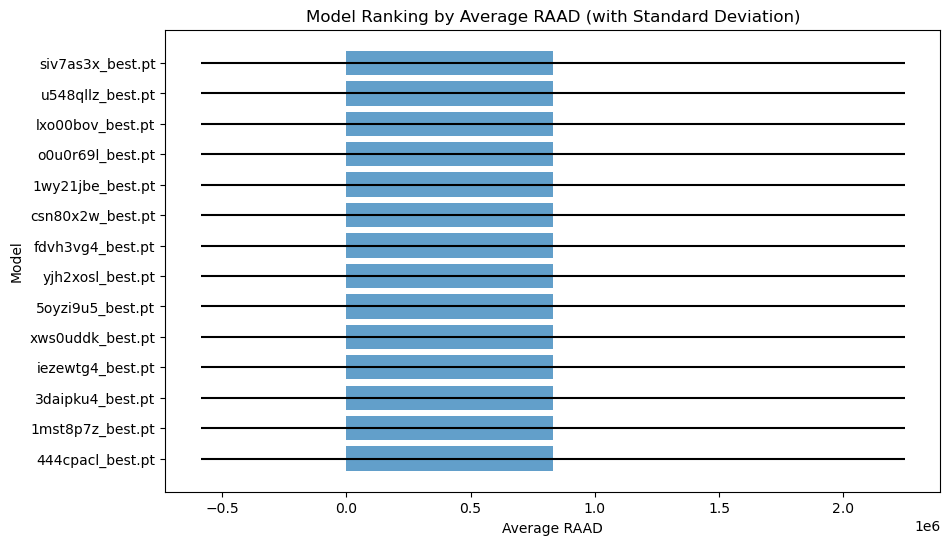

In [14]:
import matplotlib.pyplot as plt

def visualize_best_models(result_df):
    model_stats = result_df.groupby("model").agg(
        avg_raad=("error", "mean"),
        std_raad=("error", "std"),
        num_images=("image", "count")
    ).sort_values("avg_raad")

    plt.figure(figsize=(10, 6))
    plt.barh(model_stats.index, model_stats["avg_raad"], xerr=model_stats["std_raad"], alpha=0.7)
    plt.xlabel("Average RAAD")
    plt.ylabel("Model")
    plt.title("Model Ranking by Average RAAD (with Standard Deviation)")
    plt.gca().invert_yaxis()
    plt.show()

visualize_best_models(result_df)
